In [ ]:
import numpy as np
import pandas as pd
import os
import copy
os.chdir('..')
os.chdir('src')
from utils import *
from env import BlackjackEnv


In [2]:
config = {
    "num_decks": 6,
    "red_card_position": 0.2,
    "bet_size": [1],
    "actions": ["stand", "hit"],
    "num_players": 1
}
# Create environment with 6 decks (standard casino configuration)
env = BlackjackEnv(config=config)


### Helper functions

In [ ]:
def get_q_values(state_features, q_table):
    """Get Q-values for a given state"""
    if state_features in q_table:
        return np.array([q_table[state_features][0], q_table[state_features][1]])
    else:
        # Return default values based on player sum
        player_sum = state_features[0]
        if player_sum < 12:
            return np.array([-0.1, 0.5])  # Default to hit for low sums
        elif player_sum >= 20:
            return np.array([0.5, -0.1])  # Default to stand for high sums
        else:
            return np.array([0.0, 0.0])  # Neutral for middle sums

In [ ]:
def update_q_value(state_features, action, reward, next_state_features, lr, q_table, q_table_target, visit_counts, gamma):
    """Update Q-value for state-action pair using Double Q-learning"""
    if state_features not in q_table:
        return  # State not in our table
    
    # Current Q-value
    current_q = q_table[state_features][action]
    
    # If next_state_features is None, this is a terminal state
    if next_state_features is None:
        # Terminal state - no future rewards
        new_q = current_q + lr * (reward - current_q)
    else:
        # Get the next state's best action from current Q-table
        next_q_values = get_q_values(next_state_features, q_table)
        best_next_action = np.argmax(next_q_values)
        
        # Get Q-value for best action from target Q-table
        next_q_values_target = get_q_values(next_state_features, q_table_target)
        max_next_q = next_q_values_target[best_next_action]
        
        # Q-learning update formula with future rewards
        new_q = current_q + lr * (reward + gamma * max_next_q - current_q)
    
    # Update the Q-table entry
    q_table[state_features][action] = new_q
    
    # Track visit counts
    visit_counts[(state_features, action)] = visit_counts.get((state_features, action), 0) + 1
    
    return q_table

### Initialization of Q table

In [3]:
# Generate relevant states - focusing on decision points that matter
states = []
# For hard totals (no usable ace), only track 12-21
# Below 12, the optimal play is always hit
for player_sum in range(5, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 0))  # Hard total

# For soft totals (with usable ace), track 12-21
# Soft totals below 12 are impossible (A+1 = 12)
for player_sum in range(12, 22):
    for dealer_card in range(2, 12):
        states.append((player_sum, dealer_card, 1))  # Soft total

In [4]:
q_table = {}
for state in states:
    q_table[state] = {0: 0.0, 1: 0.0}  # Initialize both actions to 0
    
    # Strategic initialization
    player_sum, _, _ = state
    if player_sum >= 20:
        # For high player sums, initialize stand value higher
        q_table[state][0] = 0.5  # Stand
        q_table[state][1] = -0.1  # Hit
    elif player_sum < 12:
        # For low player sums, initialize hit value higher
        q_table[state][0] = -0.1  # Stand
        q_table[state][1] = 0.5   # Hit

# Similarly for the second Q-table
q_table2 = copy.deepcopy(q_table)

In [5]:
# Track state-action visit counts for adaptive learning rates
visit_counts = {}
for state in states:
    visit_counts[(state, 0)] = 0  # Stand
    visit_counts[(state, 1)] = 0  # Hit

### Hyperparameters

In [ ]:
# Hyperparameters
initial_lr = 0.1             # Learning rate
lr_decay_rate = 0.00005      # Learning rate decay
gamma = 1.0                  # High discount factor - long-term rewards matter more
initial_epsilon = 1.0        # Start with 100% exploration
epsilon_min = 0.01           # Minimum exploration rate
epsilon_decay = 0.99995      # Epsilon decay rate

### Training Q-table

In [9]:
print("Starting improved training...")

epsilon = initial_epsilon
lr = initial_lr

stats = {
    'wins': 0,
    'draws': 0,
    'losses': 0,
    'money_won': 0,
    'money_lost': 0
}

# Parameters for convergence
n_episodes = 1000000  # Number of episodes for training
convergence_threshold = 0.001  # Lower threshold for better stability
convergence_check_interval = 100000  # Check for convergence every N episodes
convergence_required_count = 3  # Number of consecutive checks below threshold to confirm convergence
max_episodes = n_episodes  # Maximum episodes as a fallback

# Keep a copy of the previous Q-table for comparison
previous_q = copy.deepcopy(q_table)
convergence_count = 0
converged = False
episode = 0

while episode < max_episodes and not converged:

    env.reset()
    bet_index = env.bet_space.sample()  # Always 0 for fixed betting strategy
    bet_amount = env.bets[bet_index]  # Always 1 for fixed betting strategy

    state, reward, done, _ = env.step(bet_index, action_type="bet")  # Place bet

    if done: # Natural blackjack or dealer natural
        if reward > 0:
            stats['wins'] += 1
            stats['money_won'] += reward * bet_amount
        elif reward == 0:
            stats['draws'] += 1
        else:
            stats['losses'] += 1
            stats['money_lost'] += abs(reward) * bet_amount

    state_features = get_state_features(state)

    # Play through the hand
    while not done:
        
        if state_features[0] < 12:
            # Always hit this state as it's not relevant for our training
            next_state, _, _, _ = env.step(1, action_type="move")
            next_state_features = get_state_features(next_state) if not done else None
            state = next_state
            state_features = next_state_features if next_state is not None else None
            continue
        
        # Epsilon-greedy action selection
        elif np.random.rand() < epsilon:
            action = env.move_space.sample()  # Random action
        else:
            q_values1 = get_q_values(state_features, q_table)
            q_values2 = get_q_values(state_features, q_table2)
            q_values = (q_values1 + q_values2)/2
            action = np.argmax(q_values)  # Greedy action
        
        # Take action
        next_state, reward, done, _ = env.step(action, action_type="move")
        next_state_features = get_state_features(next_state) if not done else None

        # Get adaptive learning rate for this state-action pair
        adaptive_lr = get_adaptive_lr(state_features, action, lr, visit_counts)

        # Randomly decide which Q-table to update (Double Q-learning)
        if np.random.rand() < 0.5:
            q_table = update_q_value(state_features, action, reward*bet_amount, next_state_features, adaptive_lr, q_table, q_table2, visit_counts, gamma)
        else:
            q_table2 = update_q_value(state_features, action, reward*bet_amount, next_state_features, adaptive_lr, q_table2, q_table, visit_counts, gamma)
            
        # Track outcomes
        if done:
            if reward > 0:
                stats['wins'] += 1
                stats['money_won'] += reward * bet_amount
            elif reward == 0:
                stats['draws'] += 1
            else:
                stats['losses'] += 1
                stats['money_lost'] += abs(reward) * bet_amount
        
        state = next_state
        state_features = next_state_features if next_state is not None else None
        
        if state_features is None:
            break
    
    # Decay epsilon and learning rate
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    lr = initial_lr / (1 + lr_decay_rate * episode)
    
    # Check for convergence periodically
    if episode % convergence_check_interval == 0 and episode > 0:
        # Calculate the maximum absolute difference between current and previous Q-values
        # Compute differences for "Stand" (action 0) and "Hit" (action 1)
        diff_stand = [q_table[state][0] - previous_q[state][0] for state in q_table if state in previous_q]
        diff_hit = [q_table[state][1] - previous_q[state][1] for state in q_table if state in previous_q]
        
        # Calculate the maximum absolute differences
        max_diff_stand = max(abs(diff) for diff in diff_stand) if diff_stand else 0
        max_diff_hit = max(abs(diff) for diff in diff_hit) if diff_hit else 0
        max_diff = max(max_diff_stand, max_diff_hit)
        
        if max_diff < convergence_threshold:
            convergence_count += 1
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f} (convergence count: {convergence_count}/{convergence_required_count})")
            if convergence_count >= convergence_required_count:
                print(f"Converged after {episode} episodes (max Q-value change: {max_diff:.6f})")
                converged = True
        else:
            convergence_count = 0
            print(f"Episode {episode}, max Q-value change: {max_diff:.6f}")
        
        # Store current Q-values for next comparison
        previous_q = copy.deepcopy(q_table)
    
    episode += 1

# Final statistics
total_episodes = episode
print(f"Training complete after {total_episodes} episodes.")
print(f"Win rate: {stats['wins']/total_episodes:.4f}")
print(f"Draw rate: {stats['draws']/total_episodes:.4f}")
print(f"Loss rate: {stats['losses']/total_episodes:.4f}")

Starting improved training...
Episode 100000, max Q-value change: 0.839860
Episode 200000, max Q-value change: 0.093779
Episode 300000, max Q-value change: 0.036962
Episode 400000, max Q-value change: 0.025345
Episode 500000, max Q-value change: 0.017136
Episode 600000, max Q-value change: 0.031407
Episode 700000, max Q-value change: 0.013478
Episode 800000, max Q-value change: 0.015140
Episode 900000, max Q-value change: 0.023313
Training complete after 1000000 episodes.
Win rate: 0.4292
Draw rate: 0.0856
Loss rate: 0.4852


### Testing learnt Q-table

In [10]:
print("\nFinal policy evaluation...")

eval_stats = {
    'eval wins': 0,
    'eval draws': 0,
    'eval losses': 0,
    'money won': 0,
    'money lost': 0
}

eval_episodes = 1000000 # Higher number of episodes to approximate expected reward

for _ in range(eval_episodes):
    env.reset()
    bet_index = env.bet_space.sample()
    bet_amount = env.bets[bet_index]
    state, reward, done, _ = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            eval_stats['eval wins'] += 1
            eval_stats['money won'] += reward * bet_amount
        elif reward == 0:
            eval_stats['eval draws'] += 1
        else:
            eval_stats['eval losses'] += 1
            eval_stats['money lost'] += abs(reward) * bet_amount

    state_features = get_state_features(state)

    # Training episode
    while not done:
        # Always choose the best action according to average of both Q-tables
        q_values1 = get_q_values(state_features, q_table)
        q_values2 = get_q_values(state_features, q_table2)
        avg_q_values = (q_values1 + q_values2) / 2
        action = np.argmax(avg_q_values)
        
        next_state, reward, done, _ = env.step(action, action_type="move")
        
        if done:
            if reward > 0:
                eval_stats['eval wins'] += 1
                eval_stats['money won'] += reward * bet_amount
            elif reward == 0:
                eval_stats['eval draws'] += 1
            else:
                eval_stats['eval losses'] += 1
                eval_stats['money lost'] += abs(reward) * bet_amount
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {eval_stats['eval wins']/eval_episodes:.4f}")
print(f"Draw rate: {eval_stats['eval draws']/eval_episodes:.4f}")
print(f"Loss rate: {eval_stats['eval losses']/eval_episodes:.4f}")
print(f"Money won: {eval_stats['money won']}")
print(f"Money lost: {eval_stats['money lost']}")
print(f"Average reward per hand: {(eval_stats['money won'] - eval_stats['money lost']) / eval_episodes:.4f}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4324
Draw rate: 0.0867
Loss rate: 0.4809
Money won: 455035.5
Money lost: 480875
Average reward: -0.0258


### Benchmarking with basic strategy

In [11]:
os.chdir('..')
os.chdir('strategies')
basic_strat = parse_strategy_csv('basic_strategy.csv')

In [12]:
print("\nBasic strategy evaluation...")
bench_stats = {
    'bench wins': 0,
    'bench draws': 0,
    'bench losses': 0,
    'money won': 0,
    'money lost': 0
}

bench_episodes = 1000000 # High number of episodes to approximate real expected reward

for _ in range(bench_episodes):
    env.reset()
    bet_index = env.bet_space.sample()
    bet_amount = env.bets[bet_index]

    state, reward, done, _ = env.step(bet_index, action_type="bet")  # Place bet
    if done:
        if reward > 0:
            bench_stats['bench wins'] += 1
            bench_stats['money won'] += reward * bet_amount
        elif reward == 0:
            bench_stats['bench draws'] += 1
        else:
            bench_stats['bench losses'] += 1
            bench_stats['money lost'] += abs(reward) * bet_amount

    state_features = get_state_features(state)

    # Training episode
    while not done:
        # Always choose the best action according to average of both Q-tables

        if state_features in basic_strat:
            action = 0 if basic_strat[state_features][0] > basic_strat[state_features][1] else 1
        else:
            # Default action if state not found in basic strategy (it means we are below 5)
            action = 1
        
        next_state, reward, done, _ = env.step(action, action_type="move")
        
        if done:
            if reward > 0:
                bench_stats['eval wins'] += 1
                bench_stats['money won'] += reward * bet_amount
            elif reward == 0:
                bench_stats['eval draws'] += 1
            else:
                bench_stats['eval losses'] += 1
                bench_stats['money lost'] += abs(reward) * bet_amount
        
        state = next_state
        state_features = get_state_features(state)

        if done:
            break

print(f"Final evaluation complete.")
print(f"Win rate: {bench_stats['bench wins']/bench_episodes:.4f}")
print(f"Draw rate: {bench_stats['bench draws']/bench_episodes:.4f}")
print(f"Loss rate: {bench_stats['bench losses']/bench_episodes:.4f}")
print(f"Money won: {bench_stats['money won']}")
print(f"Money lost: {bench_stats['money lost']}")
print(f"Average reward: {(bench_stats['money won'] - bench_stats['money lost'])/bench_episodes:.4f}")


Final policy evaluation...
Final evaluation complete.
Win rate: 0.4333
Draw rate: 0.0868
Loss rate: 0.4799
Money won: 455879.0
Money lost: 479889
Average reward: -0.0240


### Output creation

In [13]:
# Calculate average Q-values (ensemble approach)
avg_q_table = copy.deepcopy(q_table)
for state in q_table:
    for action in q_table[state]:
        avg_q_table[state][action] = (q_table[state][action] + q_table2[state][action]) / 2
# Save the Q-table to a CSV file
avg_q_table_df = pd.DataFrame([
    {'State': state, 'Action 0 (Stand)': actions[0], 'Action 1 (Hit)': actions[1], 'Best Action': 'Stand' if actions[0] > actions[1] else 'Hit'}
    for state, actions in avg_q_table.items()
])

# Uncomment the following line to save the Q-table to a CSV file

# avg_q_table_df.to_csv('dq_hit_stand_strat.csv', index=False)

### Comparison with basic strategy

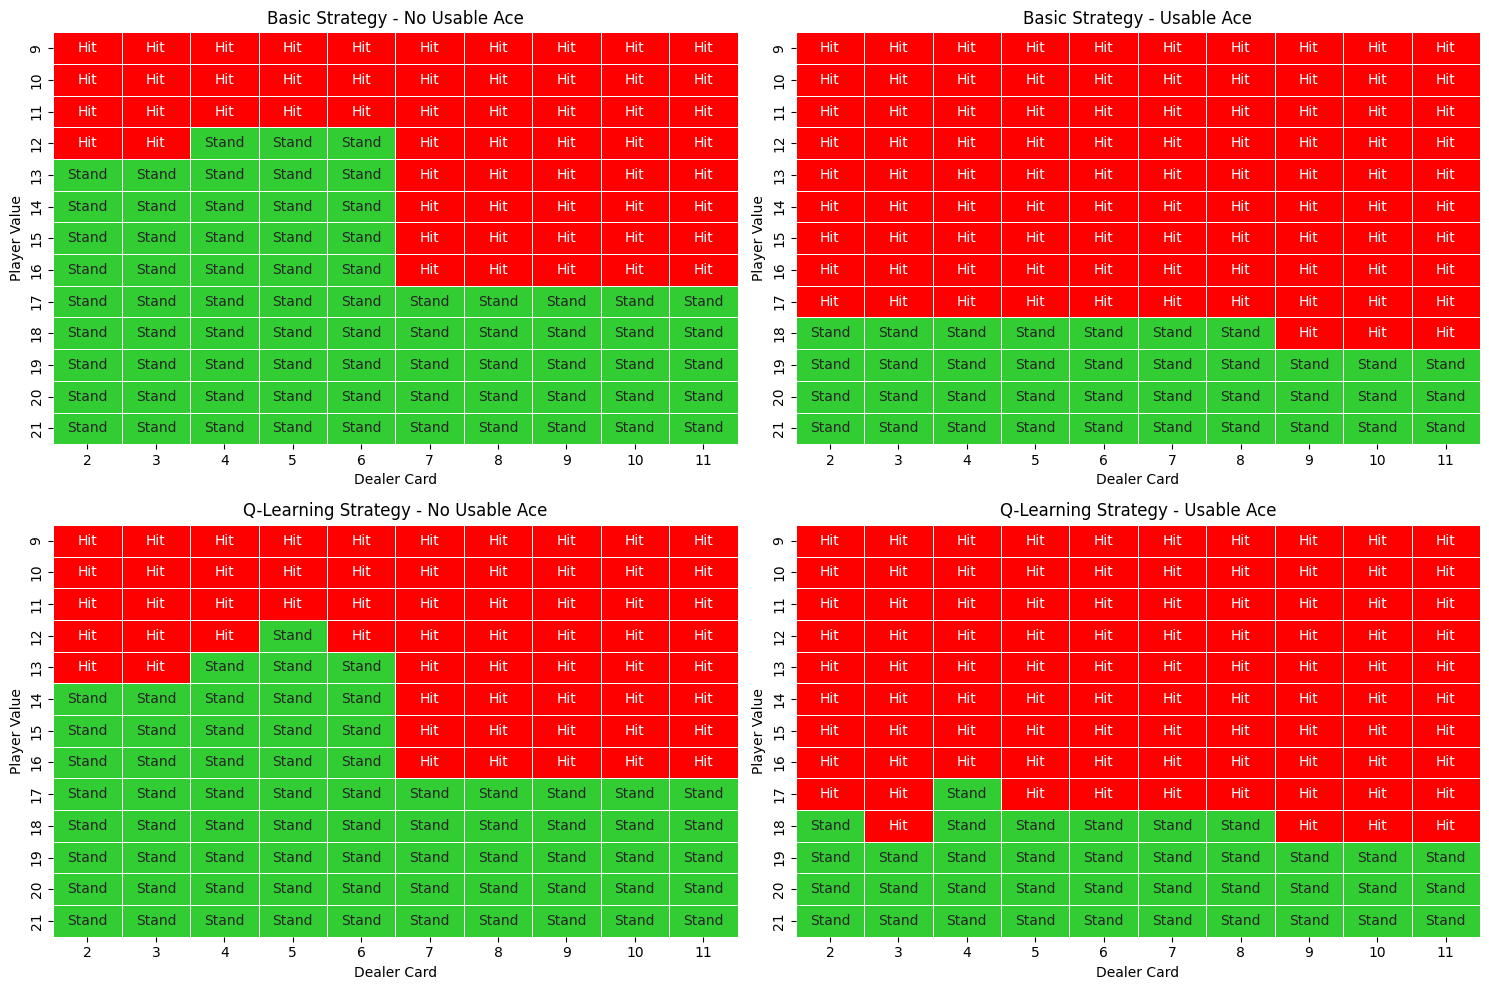

In [14]:
visualize_hit_stand("basic_strategy.csv", "dq_hit_stand_strat.csv")